In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("./")

sns.set_theme()
sns.set_context("paper")

In [2]:
from autoencode import FFAEEnsemble, standardize
from datasets import SupervisedDataset

In [3]:
data = SupervisedDataset("/export/gaon1/data/jteneggi/DL/pedreira")

torch.Size([1, 12012, 39]) torch.Size([1, 12012])


Text(0.5, 1.0, 'Downsampled traces')

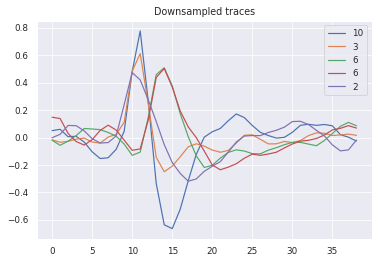

In [4]:
dataloader = DataLoader(data, batch_size=1, shuffle=False)
spikes, targets = next(iter(dataloader))
print(spikes.size(), targets.size())

for spike, target in list(zip(spikes.squeeze(), targets.squeeze()))[:5]:
    plt.plot(spike, label=target.item())
plt.legend()
plt.title("Downsampled traces")

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = FFAEEnsemble(batch_size=1, device=device)
ae.load()

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


Encoded session 0, 12012 spikes
Finding PCA projections
Learning manifold for PCA projections
Learning manifold for latent embeddings


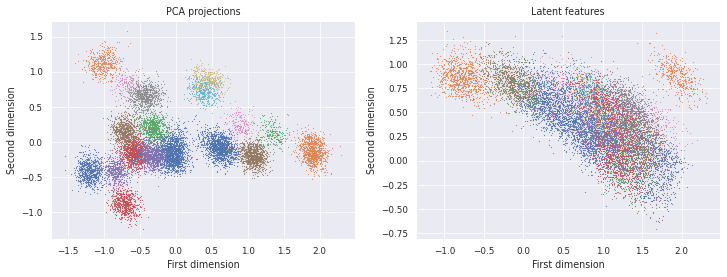

Encoded session 1, 12784 spikes
Finding PCA projections
Learning manifold for PCA projections
Learning manifold for latent embeddings


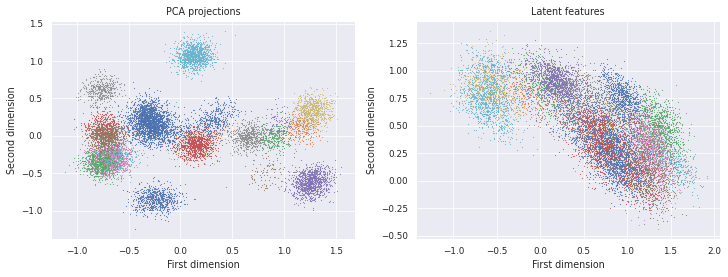

Encoded session 2, 9277 spikes
Finding PCA projections
Learning manifold for PCA projections
Learning manifold for latent embeddings


KeyboardInterrupt: 

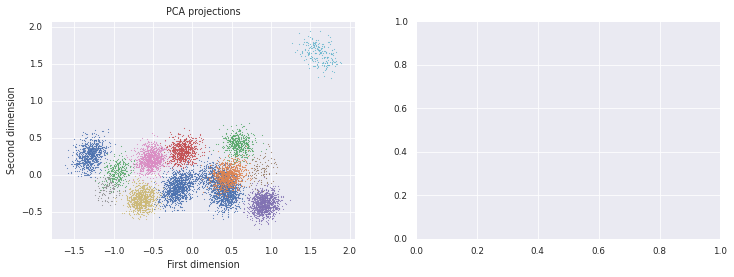

In [18]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=9)


for i, (spikes, targets) in enumerate(data):
    spikes = torch.from_numpy(spikes).float()
    spikes = spikes.to(device)
    latent_vecs = [e(spikes) for e in ae.encoders]
    latent = torch.cat(latent_vecs, dim=1).detach().cpu()
    print(f"Encoded session {i}, {spikes.size(0)} spikes")
    gt_classes = data.spike_classes[i].squeeze()
    print(f"Finding PCA projections")
    PCA_proj = pca.fit_transform(spikes.cpu())
    print(f"Learning manifold for PCA projections")
    PCA_manifold = PCA_proj[:, :2]
    # PCA_manifold = tsne.fit_transform(PCA_proj[:2])
    print(f"Learning manifold for latent embeddings")
    latent_manifold = latent[:, :2]
    # latent_manifold = tsne.fit_transform(latent[:2].cpu())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for k, (manifold, manifold_name) in enumerate(zip([PCA_manifold, latent_manifold], ["PCA projections", "Latent features"])):
        ax = axes[k]
        for c in range(20):
            c_manifold = manifold[targets == c]
            ax.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)
        ax.set_xlabel("First dimension")
        ax.set_ylabel("Second dimension")
        ax.set_title(manifold_name)
    
    plt.savefig(os.path.join("figures", f"{id}.png"))
    plt.show()
    plt.close()

In [ ]:
for spikes, targets in data:
    print(spikes.shape, targets.shape)